## Practice

### Overview of the Python Script: Stock Analysis

This Python script performs comprehensive stock analysis, calculating key statistics, generating visualizations, and summarizing stock performance. It is highly customizable and includes an option to analyze all stocks in the Dow Jones Industrial Average (DJIA).

Steps of Analysis
Data Fetching:
Fetches historical stock price data using Yahoo Finance via the yfinance library.
Adjusts time zone for proper date handling.
Calculate Returns:
Computes daily percentage returns from adjusted closing prices.
Statistics Generation:
Daily Statistics: Mean, standard deviation, and other descriptive statistics for daily returns.
Annualized Statistics:
Mean Return: Scaled by trading_days_per_year.
Standard Deviation: Adjusted using the square root of trading_days_per_year.
Total and Cumulative Returns:
Total Returns: Percentage change from the start to the end of the period.
Cumulative Returns: Growth of $1 invested over the period.
Identify Best/Worst Performers:
Determines the stock with the highest and lowest total returns.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union, List, Optional, Tuple, Dict
import yfinance as yf
import requests_cache

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format
session = requests_cache.CachedSession()

In [3]:
def analyze_stocks(
    tickers: Union[str, List[str]], 
    period: str = 'max',
    use_djia: bool = False,
    show_plots: bool = True,
    trading_days_per_year: int = 252,
    hist_bins: int = 25,
    figsize: Tuple[int, int] = (10, 6)
) -> Dict:
    """
    Performs comprehensive stock analysis including returns, statistics, and visualizations.
    
    Parameters:
    -----------
    tickers : str or list
        Stock symbols as string (space-separated) or list of strings
    period : str, default 'max'
        Time period for data collection (e.g., 'max', '5y', '1y')
    use_djia : bool, default False
        If True, analyzes all stocks in the DJIA instead of provided tickers
    show_plots : bool, default True
        If True, displays visualization plots
    trading_days_per_year : int, default 252
        Number of trading days used for annualization
    hist_bins : int, default 25
        Number of bins for histogram plots
    figsize : tuple, default (10, 6)
        Figure size for plots (width, height)
        
    Returns:
    --------
    dict
        'returns': DataFrame of daily returns
        'daily_stats': DataFrame of daily statistics
        'annual_stats': DataFrame of annualized statistics
        'total_returns': Series of total returns
        'min_max_stats': Dict of min/max performers
        'period_info': Dict of date range info
    """
    # Configure pandas display options
    pd.options.display.float_format = '{:.4f}'.format
    
    # Initialize session with cache
    session = requests_cache.CachedSession()
    
    # Get DJIA tickers if requested
    if use_djia:
        symbols = pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')[2]['Symbol']
        tickers = symbols.to_list()
    
    # Initialize tickers object and get historical data
    ticker_obj = yf.Tickers(tickers if isinstance(tickers, str) else ' '.join(tickers), session=session)
    prices = ticker_obj.history(period=period, auto_adjust=False, progress=False)
    prices.index = prices.index.tz_localize(None)
    
    # Calculate returns
    returns = prices['Adj Close'].pct_change().dropna()
    
    # Calculate basic statistics
    daily_stats = returns.describe()
    daily_means = returns.mean()
    daily_stds = returns.std()
    
    # Calculate annualized statistics
    annual_means = daily_means.mul(trading_days_per_year)
    annual_stds = daily_stds.mul(np.sqrt(trading_days_per_year))
    annual_stats = pd.DataFrame({
        'Mean (%)': annual_means * 100,
        'Std Dev (%)': annual_stds * 100
    })
    
    # Calculate total and cumulative returns
    total_returns = returns.add(1).prod().sub(1)
    cumulative_returns = returns.add(1).cumprod().sub(1)
    
    # Identify min/max performers
    min_max_stats = {
        'best_performer': {
            'ticker': total_returns.idxmax(),
            'return': total_returns.max()
        },
        'worst_performer': {
            'ticker': total_returns.idxmin(),
            'return': total_returns.min()
        }
    }
    
    if show_plots:
        # Plot 1: Risk-Return Scatter Plot
        plt.figure(figsize=figsize)
        plt.scatter(annual_stds * 100, annual_means * 100)
        plt.xlabel('Annualized Std. Dev. (%)')
        plt.ylabel('Annualized Mean Return (%)')
        title_suffix = 'DJIA Stocks' if use_djia else 'Selected Stocks'
        plt.title(f'Return Versus Risk for {title_suffix}\nfrom {returns.index[0]:%B %Y} to {returns.index[-1]:%B %Y}')
        
        for ticker in returns.columns:
            plt.text(
                x=returns[ticker].std() * np.sqrt(trading_days_per_year) * 100,
                y=returns[ticker].mean() * trading_days_per_year * 100,
                s=ticker
            )
        plt.show()
        
        # Plot 2: Distribution of Total Returns
        plt.figure(figsize=figsize)
        total_returns.mul(100).plot(kind='hist', bins=hist_bins)
        plt.xlabel('Total Return (%)')
        plt.title(f'Distribution of Total Returns for {title_suffix}\nfrom {returns.index[0]:%B %Y} to {returns.index[-1]:%B %Y}')
        plt.show()
        
        # Plot 3: Cumulative Returns for Min/Max Performers
        plt.figure(figsize=figsize)
        min_max_tickers = total_returns.sort_values()[[0, -1]].index
        (cumulative_returns[min_max_tickers]
         .mul(100)
         .plot())
        plt.ylabel('Cumulative Return (%)')
        plt.title(f'Minimum and Maximum Cumulative Returns for {title_suffix}\nfrom {returns.index[0]:%B %Y} to {returns.index[-1]:%B %Y}')
        plt.show()
    
    # Compile results
    results = {
        'returns': returns,
        'daily_stats': daily_stats,
        'annual_stats': annual_stats,
        'total_returns': total_returns,
        'cumulative_returns': cumulative_returns,
        'min_max_stats': min_max_stats,
        'period_info': {
            'start_date': returns.index[0],
            'end_date': returns.index[-1],
            'trading_days': len(returns)
        }
    }
    
    return results

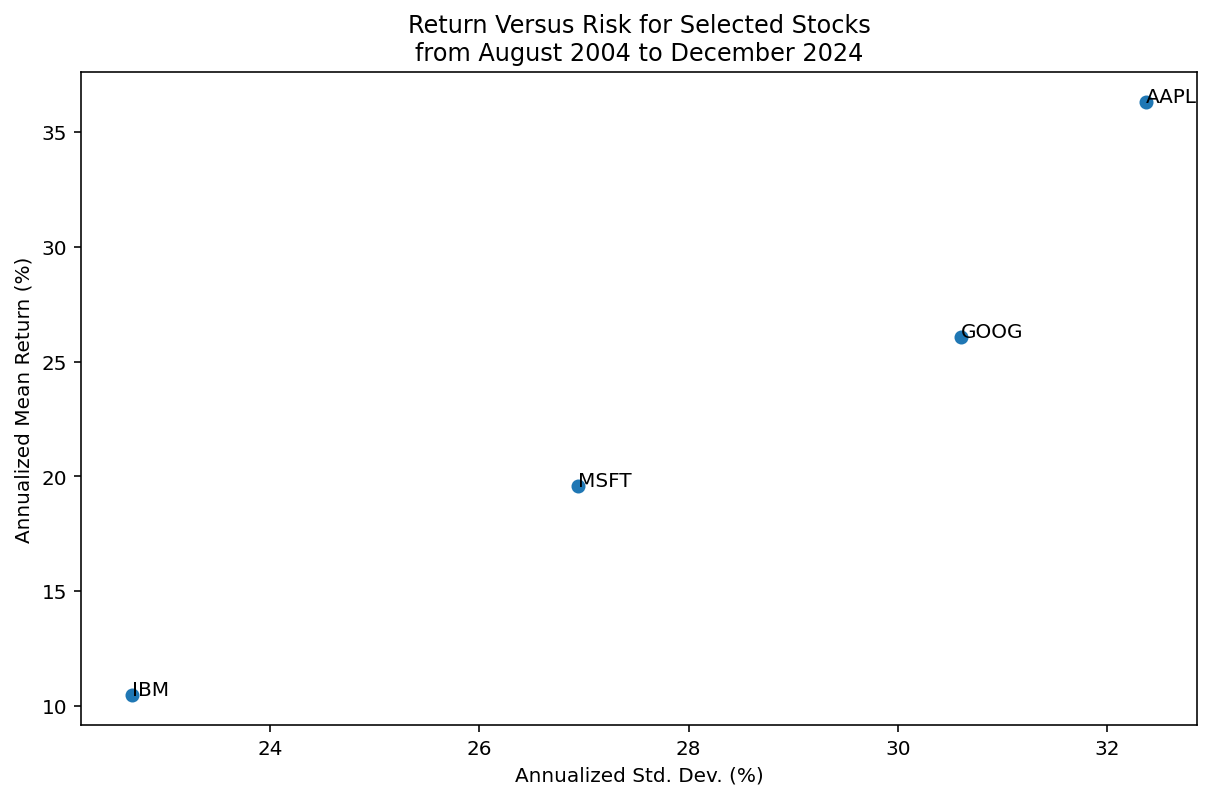

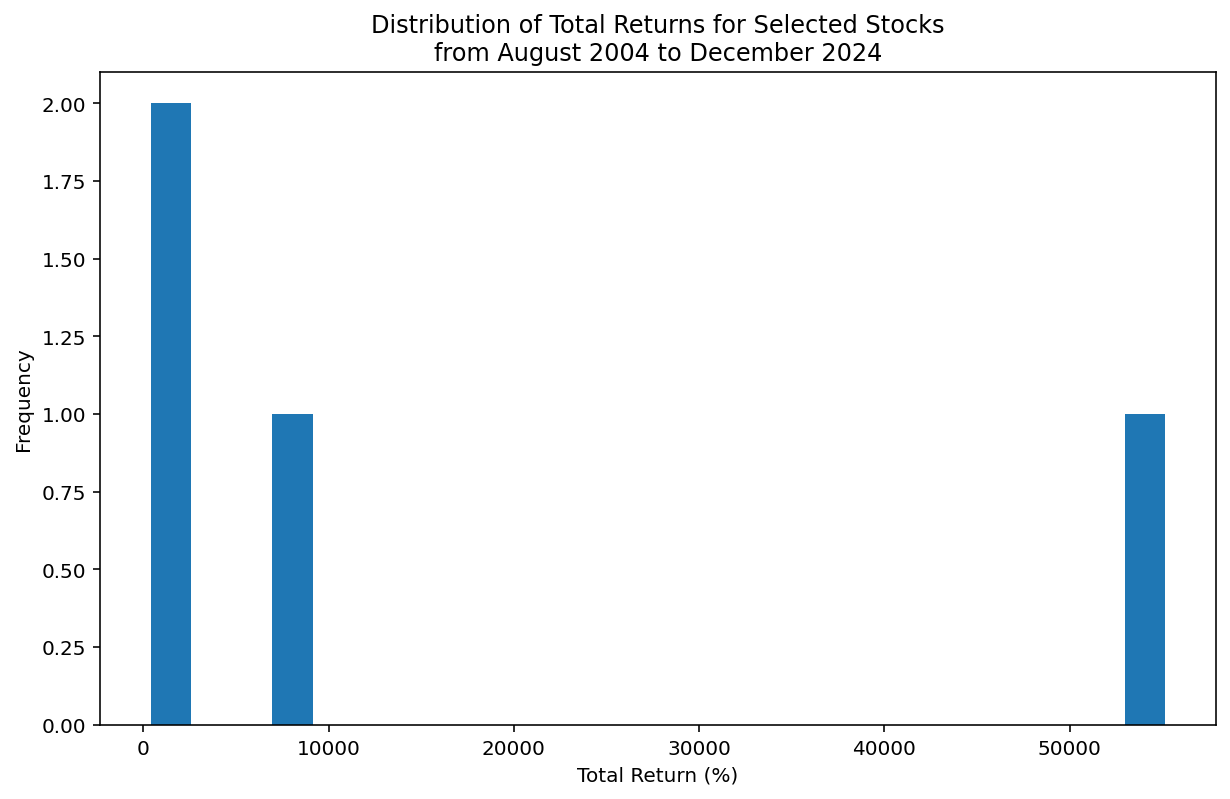

<Figure size 720x432 with 0 Axes>

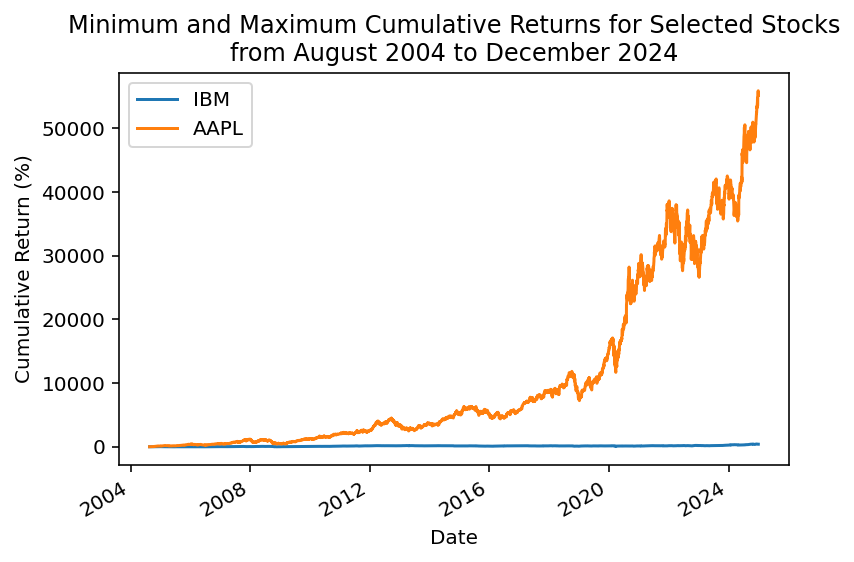

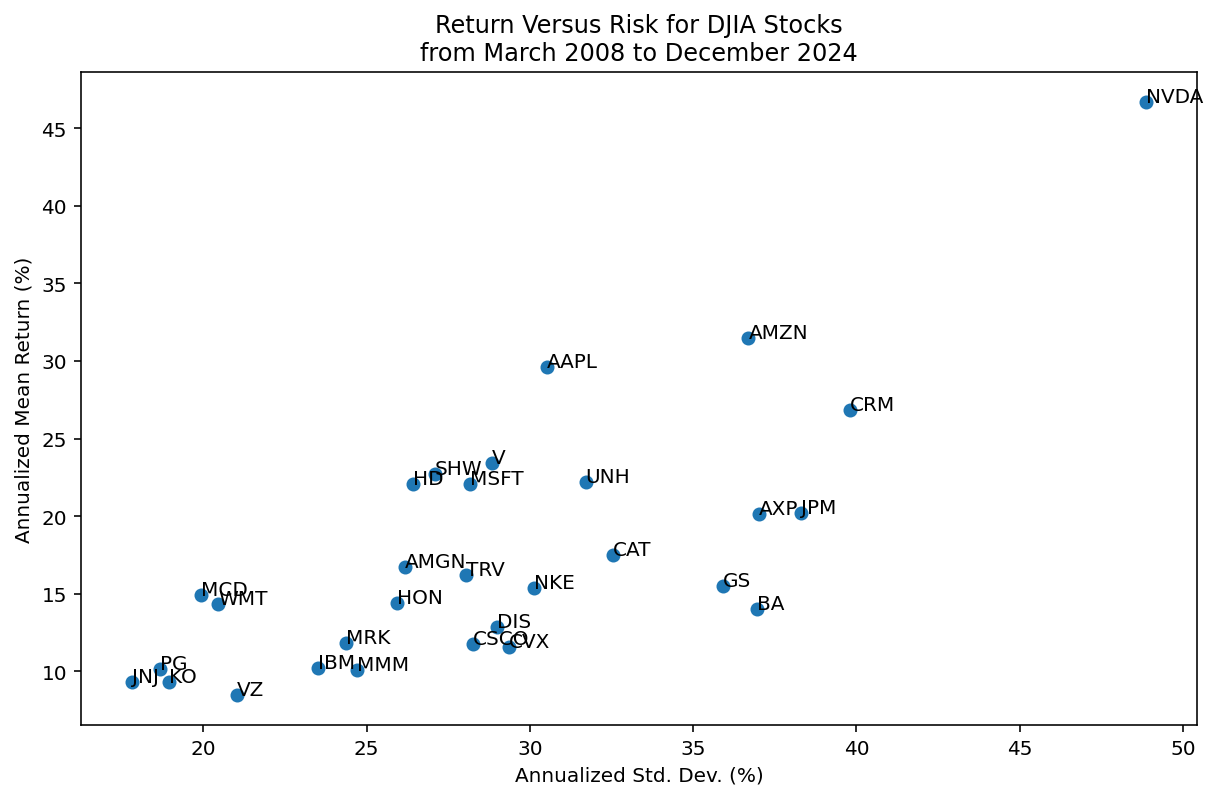

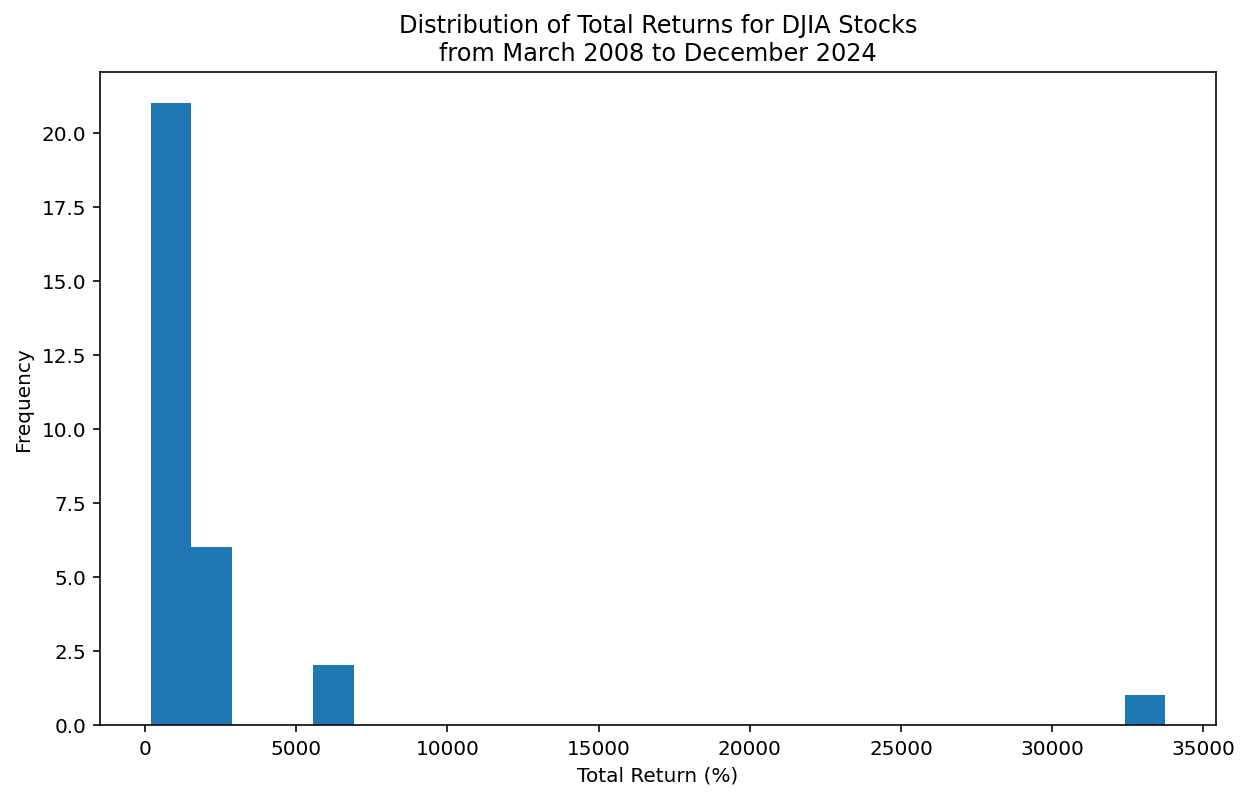

<Figure size 720x432 with 0 Axes>

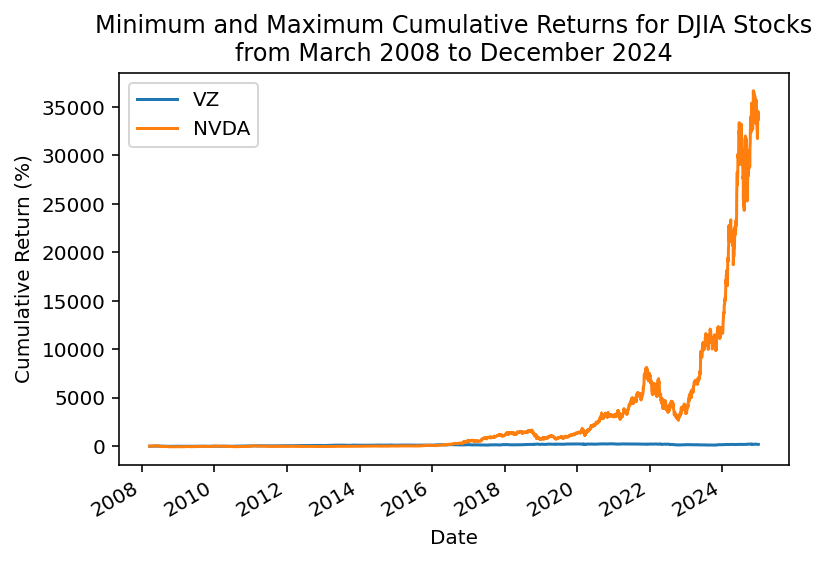

Daily Statistics:
           AAPL      GOOG       IBM      MSFT
count 5124.0000 5124.0000 5124.0000 5124.0000
mean     0.0014    0.0010    0.0004    0.0008
std      0.0204    0.0193    0.0143    0.0170
min     -0.1792   -0.1161   -0.1285   -0.1474
25%     -0.0082   -0.0079   -0.0062   -0.0071
50%      0.0012    0.0008    0.0005    0.0005
75%      0.0118    0.0102    0.0074    0.0089
max      0.1390    0.1999    0.1152    0.1860

Annualized Statistics:
      Mean (%)  Std Dev (%)
AAPL   36.3111      32.3757
GOOG   26.0799      30.6039
IBM    10.4701      22.6732
MSFT   19.5599      26.9437

Best Performer:
{'ticker': 'AAPL', 'return': 551.5130838722079}

Worst Performer:
{'ticker': 'IBM', 'return': 3.975626006140285}

Cumulative Statistics:
               AAPL    GOOG     IBM    MSFT
Date                                       
2004-08-20   0.0029  0.0794  0.0042  0.0029
2004-08-23   0.0120  0.0903 -0.0028  0.0074
2004-08-24   0.0404  0.0451 -0.0021  0.0074
2004-08-25   0.0762  0.0564  0

In [4]:
# Example usage:

# For specific stocks:
results = analyze_stocks('AAPL IBM MSFT GOOG')

# For DJIA stocks:
djia_results = analyze_stocks('', use_djia=True)

# Access various results:
print("Daily Statistics:")
print(results['daily_stats'])

print("\nAnnualized Statistics:")
print(results['annual_stats'])

print("\nBest Performer:")
print(results['min_max_stats']['best_performer'])

print("\nWorst Performer:")
print(results['min_max_stats']['worst_performer'])

print("\nCumulative Statistics:")
print(results['cumulative_returns'])